In [117]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os 
from scipy.stats import binom_test
from sequencing_tools.stats_tools import p_adjust
from sequencing_tools.fastq_tools import reverse_complement
from collections import defaultdict
from scipy.stats import beta
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)



fast_btest = np.vectorize(binom_test)

def fix_simple_repeats(p_df):
    simple_repeat_count = p_df\
        .pipe(lambda d: d[d.gene_name.str.contains('Simple_repeat')]) \
        .assign(oligo = lambda d: d.gene_name.str.extract('([ACTG]+)', expand=True).iloc[:,0]) \
        .assign(rev_oligo = lambda d: d.oligo.map(reverse_complement)) \
        .groupby(['oligo','rev_oligo'], as_index=False)\
        .agg({'sense':'sum',
             'antisense':'sum'})
    
    repeat_count_dict = defaultdict(lambda: defaultdict(int))
    
    for i, row in simple_repeat_count.iterrows():
        repeat_count_dict[row['oligo']]['sense'] = row['sense']
        repeat_count_dict[row['oligo']]['antisense'] = row['antisense']
    
    
    return simple_repeat_count\
        .assign(rev_sense = lambda d: d.rev_oligo.map(lambda x: repeat_count_dict[x]['sense'])) \
        .assign(rev_antisense = lambda d: d.rev_oligo.map(lambda x: repeat_count_dict[x]['antisense'])) \
        .assign(combine_sense = lambda d: d.sense + d.rev_antisense) \
        .assign(combine_antisense = lambda d: d.antisense + d.rev_sense) \
        .assign(gene_id = 'Simple_repeats')\
        .assign(gene_name = lambda d: 'Simple_repeats:(' + d.oligo + ')n' ) \
        .filter(regex = 'gene|combi')\
        .rename(columns = {'combine_sense':'sense',
                          'combine_antisense': 'antisense'})

In [135]:
count_table = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv'
df = pd.read_table(count_table)
df.head()

,gene_id,gene_name,gene_type,grouped_type,IGG-cf_R1_001:all:antisense,IGG-cf_R1_001:all:sense,IGG-cf_R1_001:dedup:antisense,IGG-cf_R1_001:dedup:sense,QCF1_R1_001:all:antisense,QCF1_R1_001:all:sense,...,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense,genome-sim_R1_001:all:antisense,genome-sim_R1_001:all:sense,genome-sim_R1_001:dedup:antisense,genome-sim_R1_001:dedup:sense
0,.,.,No features,No features,0,0,0,0,1164939,69311,...,0,0,0,0,0,0,26000336,26009990,25968043,25977719
1,.,.,tRNA,tRNA,0,0,0,0,10237961,0,...,0,0,0,0,0,0,568,0,523,0
2,.,No features:.,Repeats,Repeats,3745,4542,2989,3742,35812,17223,...,94446,92684,159513,155574,101781,100419,17259398,17273200,17259009,17272829
3,18S_rRNA,18S_rRNA,rDNA,rRNA,0,0,0,0,734,175520,...,0,0,0,0,0,0,225,252,225,252
4,28S_rRNA,28S_rRNA,rDNA,rRNA,0,0,0,0,1089,384807,...,0,0,0,0,0,0,506,533,506,533


In [162]:
def get_repeat_df(sample_regex=None):
    p_df = df\
        .pipe(lambda d: d[~d.gene_name.str.contains('No features')])\
        .query('grouped_type == "Repeats"')\
        .filter(regex = 'gene|grouped|%s' %(sample_regex)) \
        .pipe(pd.melt, 
              id_vars = ['gene_id','gene_name','gene_type','grouped_type'],
              var_name = 'samplename', 
              value_name = 'read_count') \
        .assign(strand = lambda d: d.samplename.str.split(':',expand=True).iloc[:, -1]) \
        .groupby(['gene_id','gene_name','strand'], as_index=False)\
        .agg({'read_count':'sum'}) \
        .pipe(pd.pivot_table, 
              index=['gene_id','gene_name'], 
              columns = 'strand', 
              values='read_count') \
        .reset_index() \
        .pipe(lambda d: d[~d.gene_id.str.contains('rRNA|tRNA|RNA')]) \
        .query('(antisense + sense) > 0') \
        .pipe(lambda d: pd.concat([d.query('gene_id!="Simple_repeat"'),
                              fix_simple_repeats(d)], sort=True))
    return p_df
    
def model_df(p_df, ax, title=''):
    # construct prior
    hi_df = p_df\
        .query('(sense + antisense) > 50')\
        .assign(percentage_sense = lambda d: d.sense/(d.sense + d.antisense))\
        .query('0 < percentage_sense < 1')
    a, b, _, _  = beta.fit(data = hi_df.percentage_sense.values, floc=0, fscale=1)
    
    
    sns.distplot(hi_df.percentage_sense, label = 'High count repeats (>50 fragments)', ax =ax, hist_kws={'alpha':0.5})
    sns.distplot(beta.ppf(np.arange(0.001, 1, 0.01), a,b), label = 'Fitted beta-binomial', ax = ax, hist_kws={'alpha':0.5})
    ax.legend(frameon=False, bbox_to_anchor=(0.6,1.1))
    ax.set_xlabel('Sense strand fragments (fraction)')
    ax.set_ylabel('Density')
    ax.set_xlim(0, 1)
    ax.set_title(title, fontsize=15)
    sns.despine()
    return a, b


def update_beta(a, b, sense, antisense):
    return (a + sense) / (a + b + sense + antisense)
                          

def update_posterior(p_df, a, b):
    return p_df \
        .assign(posterior = lambda d: update_beta(a,b, d.sense, d.antisense))

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


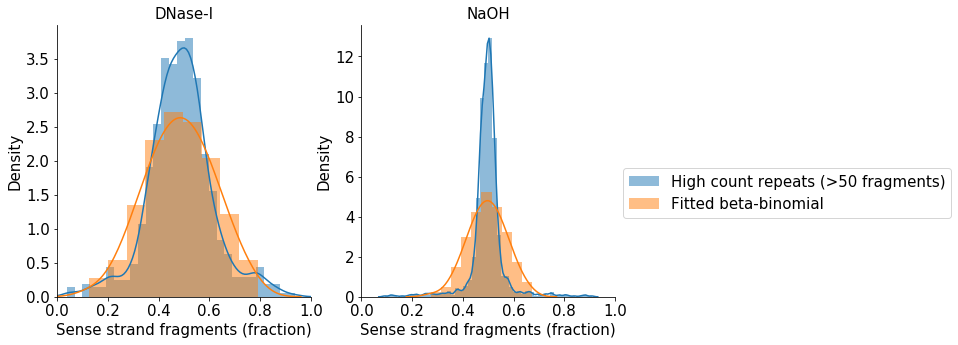

In [172]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
sample_regex = 'Q[cC][fF][0-9]+'
p_df = get_repeat_df(sample_regex = sample_regex)
a, b = model_df(p_df, ax, title = 'DNase-I')
ax.legend().set_visible(False)

ax = fig.add_subplot(122)
sample_regex = '[Nn][aA]'
naoh_p_df = get_repeat_df(sample_regex = sample_regex)
naoh_a, naoh_b = model_df(naoh_p_df, ax, title= 'NaOH')
ax.legend(bbox_to_anchor = (1,0.5), fontsize=15)

In [163]:
dnase_posterior_df = update_posterior(p_df, a, b)
naoh_posterior_df = update_posterior(naoh_p_df, naoh_a, naoh_b)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


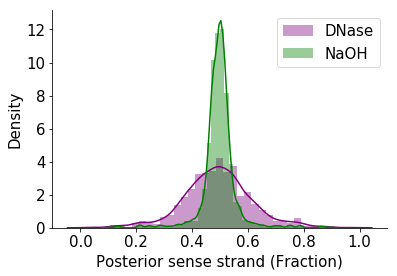

In [180]:
ax = plt.subplot(111)
sns.distplot(dnase_posterior_df.posterior, label = 'DNase', color = 'purple')
sns.distplot(naoh_posterior_df.posterior, label = 'NaOH', color = 'green')
ax.set_xlabel('Posterior sense strand (Fraction)')
sns.despine()
ax.legend(fontsize=15)
ax.set_ylabel('Density')

In [183]:
posterior_df = pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
         naoh_posterior_df.assign(treatment='NaOH')]) \
    .pipe(pd.melt, id_vars = ['treatment','gene_name','gene_id']) \
    .assign(variable = lambda d: d.treatment + ': ' + d.variable) \
    .pipe(pd.pivot_table, index=['treatment','gene_name', 'gene_id'],
         columns = 'variable', values = 'value', fill_value = 0) \
    .reset_index()
posterior_df.head()

variable,treatment,gene_name,gene_id,DNase: antisense,DNase: posterior,DNase: sense,NaOH: antisense,NaOH: posterior,NaOH: sense
0,DNase,DNA:Arthur1,hAT-Tip100,72,0.449906,58,0,0.0,0
1,DNase,DNA:Arthur1A,hAT-Tip100,14,0.483466,13,0,0.0,0
2,DNase,DNA:Arthur1B,hAT-Tip100,53,0.544599,65,0,0.0,0
3,DNase,DNA:Arthur1C,hAT-Tip100,14,0.483466,13,0,0.0,0
4,DNase,DNA:BLACKJACK,hAT-Blackjack,56,0.502697,57,0,0.0,0


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


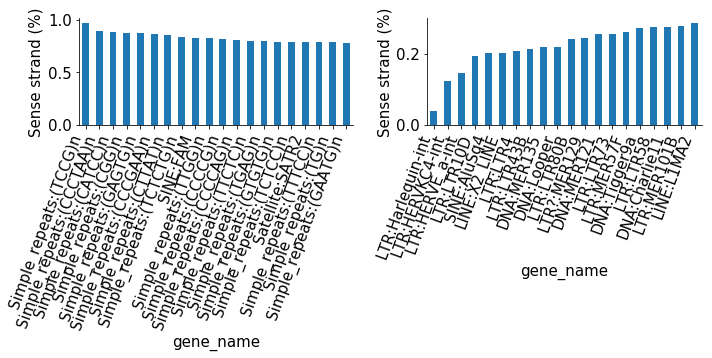

In [56]:
fig = plt.figure(figsize= (10,5))

top_n = 20

ax = fig.add_subplot(121)
posterior_df\
    .nlargest(top_n, 'posterior')\
    .set_index('gene_name')\
    .filter(['posterior'])\
    .plot.bar(ax=ax)
ax.set_ylabel('Sense strand (%)')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha='right')



ax = fig.add_subplot(122)
posterior_df\
    .pipe(lambda d: d[~d.gene_name.str.contains('Simple')])\
    .nsmallest(top_n, 'posterior')\
    .set_index('gene_name')\
    .filter(['posterior'])\
    .plot.bar(ax=ax)
ax.set_ylabel('Sense strand (%)')
ax.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha='right')
fig.tight_layout()
sns.despine()

In [57]:
posterior_df[posterior_df.gene_name.str.contains('HSAT')]

,antisense,gene_id,gene_name,sense,posterior
773,8,Satellite,Satellite:HSAT5,6,0.456925
775,4,Satellite,Satellite:HSATI,6,0.536606
776,2141,Satellite,Satellite:HSATII,2327,0.520719
1197,25,centr,Satellite:HSAT4,47,0.627619


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


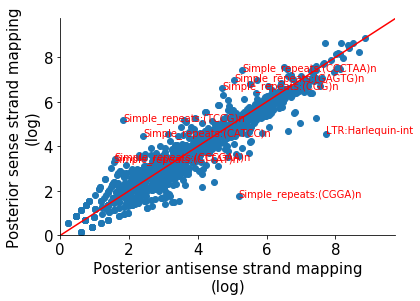

In [68]:
posterior_df['total'] =  posterior_df.antisense + posterior_df.sense
posterior_df['x'] = np.log((1 - posterior_df.posterior) * (posterior_df.total))
posterior_df['y'] = np.log(posterior_df.posterior * posterior_df['total'])

ax = plt.subplot(111)
ax.scatter(posterior_df['x'],posterior_df['y'])
ax.plot([0,20],[0,20], color = 'red')
ax.set_ylabel('Posterior sense strand mapping\n(log)')
ax.set_xlabel('Posterior antisense strand mapping\n(log)')
ax.set_xlim(0,x.max() * 1.1)
ax.set_ylim(0,y.max() * 1.1)
sns.despine()

for i, row in posterior_df.iterrows():
    if row['posterior'] > 0.85 or row['posterior'] < 0.05:
        ax.text(row['x'],row['y'],
               row['gene_name'], color='red',ha='left')


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


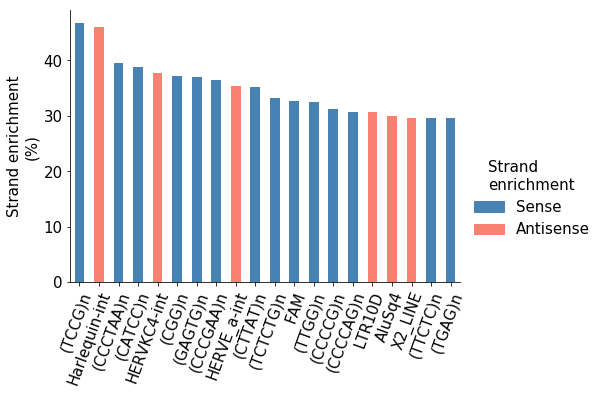

In [194]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
top_n = 20
plot_df = posterior_df\
    .assign(naoh_posterior = lambda d: np.where(d['NaOH: posterior'] > 0, d['NaOH: posterior'], 0.5))\
    .pipe(lambda d: d[d['DNase: posterior'] > 0])\
    .pipe(lambda d: d[~((d.gene_id.str.contains('Simple')) & (d['DNase: posterior'] < 0.5))])\
    .assign(new_posterior = lambda d: np.abs(d['DNase: posterior'] - d['naoh_posterior']) * 100)\
    .nlargest(top_n, 'new_posterior')\
    .set_index('gene_name')
colors = np.where(plot_df['DNase: posterior'].astype(float) < 0.5,'salmon','steelblue')
plot_df\
    .reset_index()\
    .plot\
    .bar('gene_name','new_posterior', ax=ax, color = colors.tolist())
ax.set_ylabel('Strand enrichment\n(%)')
ax.set_xlabel('')
ax.legend().set_visible(False)
xt = ax.set_xticklabels([x.get_text().split(':')[1] for x in ax.get_xticklabels()], 
                        rotation = 70, 
                        ha='right', rotation_mode='anchor')
sns.despine()

pat = [mpatches.Patch(color=col, label=lab) for col, lab in zip(['steelblue','salmon'], 
                                                                ['Sense','Antisense'])]
lgd = ax.legend(handles=pat, bbox_to_anchor = (1,0.5), 
          title='Strand\nenrichment', fontsize=15,
         frameon=False)
lgd =plt.setp(lgd.get_title(),fontsize=15)